In [11]:
!pip uninstall -y mlflow
!pip install mlflow==2.8.1



Found existing installation: mlflow 2.12.1
Uninstalling mlflow-2.12.1:
  Successfully uninstalled mlflow-2.12.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 4.7 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 7.2.1
    Uninstalling importlib_metadata-7.2.1:
      Successfully uninstalled importlib_metadata-7.2.1
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.2
    Uninstalling cloudpickle-3.1.2:
      Successfully uninstalled cloudpickle-3.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 4.25.8 which is incompatible.
dask 2025.12.0 requires cloudpickle>=3.0.0, but you have cloudpickle 2.2.1 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompa

In [3]:
# MLflow pour le suivi des expériences
import mlflow
import mlflow.sklearn

print(mlflow.__version__)


2.8.1


In [4]:
# ============================
# 1. IMPORTS DES LIBRAIRIES
# ============================

# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Préparation des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Évaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report





In [5]:
# ============================
# 2. CONFIGURATION MLFLOW
# ============================

# On crée une expérience MLflow dédiée à notre projet
mlflow.set_experiment("cardio-health-risk-prediction")


2026/02/23 17:37:22 INFO mlflow.tracking.fluent: Experiment with name 'cardio-health-risk-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/816133936915429949', creation_time=1771868242322, experiment_id='816133936915429949', last_update_time=1771868242322, lifecycle_stage='active', name='cardio-health-risk-prediction', tags={}>

In [6]:
# ============================
# 3. CHARGEMENT DU DATASET
# ============================

# Le dataset contient des informations de santé et de mode de vie
df = pd.read_csv("CVD_cleaned.csv")  # adapte le nom du fichier

# Aperçu des premières lignes
df.head()


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [7]:
# ============================
# 4. DIMENSIONS & TYPES
# ============================

print("Dimensions du dataset :", df.shape)
df.dtypes


Dimensions du dataset : (308854, 19)


,0
General_Health,object
Checkup,object
Exercise,object
Heart_Disease,object
Skin_Cancer,object
Other_Cancer,object
Depression,object
Diabetes,object
Arthritis,object
Sex,object


In [8]:
# ============================
# 5. VALEURS MANQUANTES
# ============================

df.isnull().sum()


,0
General_Health,0
Checkup,0
Exercise,0
Heart_Disease,0
Skin_Cancer,0
Other_Cancer,0
Depression,0
Diabetes,0
Arthritis,0
Sex,0


 Vérification des valeurs manquantes
 ----------------------------------
L'analyse des valeurs manquantes montre que l'ensemble des colonnes du dataset
ne contient aucune valeur nulle. Cela signifie que les données sont complètes et qu'aucune étape d'imputation n'est nécessaire à ce stade.
df.isnull().sum()


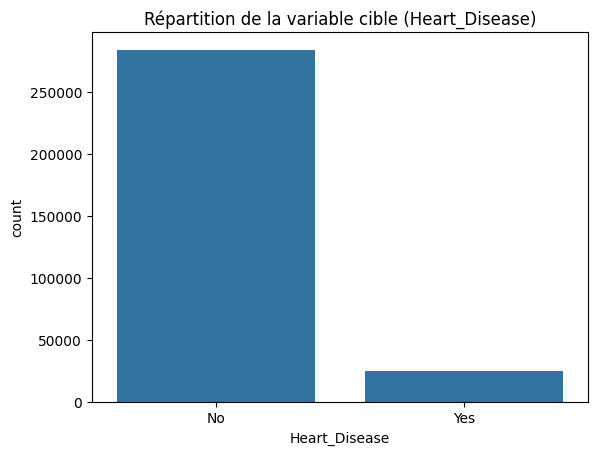

In [9]:
# ============================
# 6. DISTRIBUTION DE LA CIBLE
# ============================

# Heart_Disease est la variable que l'on veut prédire
sns.countplot(x="Heart_Disease", data=df)
plt.title("Répartition de la variable cible (Heart_Disease)")
plt.show()


** Analyse de la variable cible (Heart_Disease)**

 La visualisation montre une forte disproportion entre les deux classes :
La classe "No" est largement majoritaire : la grande majorité des
individus ne présentent pas de maladie cardiaque.

La classe "Yes" est minoritaire : seule une petite partie de la population est concernée par la maladie cardiaque.

Cette distribution révèle un déséquilibre de classes (class imbalance).Ce type de déséquilibre peut poser problème lors de l'entraînement du modèle, car celui-ci pourrait être tenté de prédire systématiquement "No" tout en obtenant une bonne accuracy sans réellement apprendre à détecter les cas positifs.
Pour corriger ce déséquilibre, nous allons utiliser :
 - Utiliser des poids de classe (class weights) dans les modèles pour pénaliser davantage les erreurs sur la classe "Yes"
 Ces stratégies permettent d'améliorer la capacité du modèle à détecter les cas
 de maladie cardiaque, ce qui est essentiel dans un contexte médical.



In [10]:
# ============================
# 5. SÉPARATION FEATURES / CIBLE
# ============================

TARGET_COL = "Heart_Disease"

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])


 Séparation des variables explicatives (features) et de la variable cible

La variable 'Heart_Disease' est la cible que l'on souhaite prédire. On la place donc dans y.
Toutes les autres colonnes constituent les variables explicatives (X), c’est-à-dire les informations utilisées par le modèle pour apprendre à prédire la présence ou non d'une maladie cardiaque.
 Cette séparation est une étape essentielle avant le prétraitement, le rééquilibrage éventuel des classes et l'entraînement du modèle.



In [11]:
# ============================
# 6. ENCODAGE DES VARIABLES CATÉGORIELLES
# ============================

categorical_cols = X.select_dtypes(include=["object"]).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


 Encodage des variables catégorielles

 Certaines colonnes du dataset sont de type catégoriel (object). Les modèles de machine learning ne pouvant traiter directement ce type de données,il est nécessaire de les convertir en variables numériques.
 Ici, on identifie d'abord toutes les colonnes catégorielles, puis on applique un encodage One-Hot (via pd.get_dummies). L'option drop_first=True permet d'éviter la multicolinéarité en supprimant la première modalité de chaque variable encodée. Le résultat est un nouveau jeu de données (X_encoded) entièrement numérique,prêt pour les étapes suivantes : normalisation, rééquilibrage éventuel des classes et entraînement du modèle.



In [12]:
# ============================
# 7. GESTION DES VALEURS MANQUANTES
# ============================

X_encoded = X_encoded.fillna(X_encoded.median())


In [13]:
# ============================
# 8. NORMALISATION DES VARIABLES NUMÉRIQUES
# ============================

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

scaler = StandardScaler()
X_scaled = X_encoded.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])


# Normalisation des variables numériques
Les modèles de machine learning sont sensibles aux différences d'échelle entre les variables numériques. Certaines colonnes peuvent avoir des valeurs très élevées (ex : poids, taille), tandis que d'autres ont des valeurs plus petites. Pour éviter que les variables à grande échelle dominent l'apprentissage du modèle,  on applique une normalisation via StandardScaler. Cette méthode transforme chaque  variable pour qu'elle ait :  - une moyenne de 0  - un écart-type de 1  Cela permet d'améliorer la stabilité, la vitesse d'entraînement et les performances  des modèles sensibles à l'échelle des données (ex : régression logistique, SVM). Le résultat est stocké dans X_scaled, qui contient les mêmes colonnes que X_encoded, mais avec les variables numériques normalisées.

In [14]:
# ============================
# 9. SPLIT TRAIN / TEST
# ============================

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.4, random_state=42, stratify=y
)


**Séparation du jeu de données en ensembles d'entraînement et de test**

 On divise ici les données en deux parties :
- X_train, y_train : utilisés pour entraîner le modèle
 - X_test, y_test   : utilisés pour évaluer les performances sur des données jamais vues par le modèle, afin de mesurer sa capacité de généralisation. Le paramètre test_size=0.4 signifie que 40% des données seront réservées au test, tandis que 60% serviront à l'entraînement.L'argument stratify=y est essentiel dans le cas d'un dataset déséquilibré : il garantit que la proportion de classes ("Yes" / "No") est la même dans les ensembles d'entraînement et de test. Cela évite d'obtenir un jeu de test trop déséquilibré, ce qui fausserait l'évaluation du modèle.
Le random_state=42 assure la reproductibilité du split.



In [16]:
# ============================
# 12. RANDOM FOREST + CLASS_WEIGHT
# ============================

with mlflow.start_run(run_name="RandomForest_class_weight"):

    rf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",  # compensation automatique du déséquilibre
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label="Yes")
    auc = roc_auc_score(y_test, y_proba)

    print("Accuracy :", acc)
    print("F1-score :", f1)
    print("ROC AUC :", auc)
    print("\nClassification report :\n", classification_report(y_test, y_pred))

    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("class_weight", "balanced")

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", auc)

    mlflow.sklearn.log_model(rf, "cardio_model")
    mlflow.sklearn.log_model(scaler, "scaler")


Accuracy : 0.918966829094559
F1-score : 0.062201405152224824
ROC AUC : 0.8154605572656508

Classification report :
               precision    recall  f1-score   support

          No       0.92      1.00      0.96    113554
         Yes       0.48      0.03      0.06      9988

    accuracy                           0.92    123542
   macro avg       0.70      0.52      0.51    123542
weighted avg       0.89      0.92      0.89    123542



2026/02/23 18:20:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Analyse des résultats (RandomForest)

**Modèle 1 **: RandomForest + class_weight

Accuracy : 0.9189
F1-score : 0.0622
ROC AUC : 0.8154
Cela signifie que Accuracy très élevée (0.91)  
→ mais c’est trompeur, car le dataset est déséquilibré.

F1-score catastrophique (0.06)  
→ notre modèle ne détecte presque aucun malade.

Recall pour “Yes” = 0.03  
→ il détecte seulement 3% des malades.

 Conclusion
Ce modèle est dangereux dans un contexte médical.
Il prédit “No” presque tout le temps.

In [18]:
# ============================
# 13. LOGISTIC REGRESSION + CLASS_WEIGHT
# ============================

with mlflow.start_run(run_name="LogisticRegression_class_weight"):

    # Modèle linéaire simple et interprétable
    log_reg = LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  # gestion du déséquilibre
        solver="liblinear"        # stable pour les datasets déséquilibrés
    )

    # Entraînement
    log_reg.fit(X_train, y_train)

    # Prédictions
    y_pred = log_reg.predict(X_test)
    y_proba = log_reg.predict_proba(X_test)[:, 1]

    # Métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label="Yes")
    auc = roc_auc_score(y_test, y_proba)

    print("Accuracy :", acc)
    print("F1-score :", f1)
    print("ROC AUC :", auc)
    print("\nClassification report :\n", classification_report(y_test, y_pred))

    # Log MLflow
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", auc)

    mlflow.sklearn.log_model(log_reg, "cardio_model")
    mlflow.sklearn.log_model(scaler, "scaler")


Accuracy : 0.7366806430201874
F1-score : 0.32808014045233913
ROC AUC : 0.8373763189021959

Classification report :
               precision    recall  f1-score   support

          No       0.98      0.73      0.84    113554
         Yes       0.21      0.80      0.33      9988

    accuracy                           0.74    123542
   macro avg       0.59      0.76      0.58    123542
weighted avg       0.91      0.74      0.80    123542



2026/02/23 18:26:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


**Modèle 2** : Logistic Regression + class_weight

Accuracy : 0.7366
F1-score : 0.3280
ROC AUC : 0.8373
 Cela veut dire qu' Accuracy plus faible (0.73)  
→ normal, car il détecte plus de malades.
F1-score beaucoup plus élevé (0.33)  
→ notre modèle est bien meilleur pour détecter les malades.
Recall pour “Yes” = 0.80  
→ il détecte 80% des malades.

 Conclusion

Ce modèle est bien meilleur pour la santé publique.
Il détecte les malades, même si l’accuracy baisse.

Dans un contexte médical, on choisit le modèle qui :
détecte le plus de malades (Recall),minimise les faux négatifs,a un F1-score correct,a un bon ROC AUC est stable et interprétable
 Le meilleur modèle est clairement : Logistic Regression + class_weight="balanced"

In [20]:
# ============================
# 14. EXPORT DU MEILLEUR MODÈLE
# ============================

import pickle

# Ici, on choisit le meilleur modèle selon les métriques.
# Dans ton cas : Logistic Regression (balanced)
best_model = log_reg

# On crée un package contenant tout ce dont l'API aura besoin
model_package = {
    "model": best_model,                     # le modèle entraîné
    "scaler": scaler,                        # le scaler utilisé pour normaliser les données
    "features": X_scaled.columns.tolist()    # la liste des colonnes dans le bon ordre
}

# On sauvegarde le package dans un fichier pickle
with open("cardio_model.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("Modèle sauvegardé dans cardio_model.pkl")


Modèle sauvegardé dans cardio_model.pkl
